# Github Star Spead Analyze 

分析github star 是怎么增长的。 


## 数据源

Github 提供了API 可以获得发生在特定仓库的 Event , 其中包含了 一个项目被 Star 的事件。
我们定义了下面的函数来获得一个项目的所有Star 事件。 
注意: 由于历史原因，事件类型叫做 WatchEvent .

In [1]:
from github import Github

def get_star_events(repo_fullname):
    repo = Github().get_repo(repo_fullname)
    events = repo.get_events()
    return filter(lambda x:x.type == 'WatchEvent', events)


In [2]:
events = get_star_events("ftao/vpn-deploy-playbook")

目前我们只关心 who / when 

In [12]:
for event in itertools.islice(events, 0, 10):
    print (event.actor.login, event.created_at)

dmexe 2016-01-18 22:57:06
cchchoi1986 2016-01-14 09:37:19
JmmBite 2016-01-11 07:49:34
SquirrelMajik 2016-01-08 12:27:04
yangwe1 2016-01-08 02:52:02
cheekyhalf 2016-01-07 16:48:37
GonZo 2016-01-07 16:48:30
mthrynn 2016-01-06 23:09:19
else 2016-01-06 15:11:17
vinc3nt 2016-01-06 12:09:55


我们接下来看一下Star数量随时间变化的趋势。

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

In [15]:
star_events = list(get_star_events('ftao/vpn-deploy-playbook'))

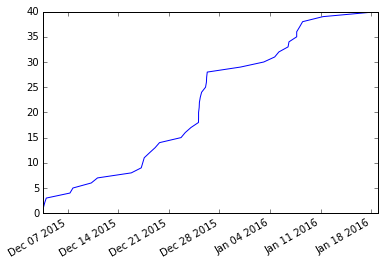

In [16]:
ts = pd.Series(np.ones(len(star_events)), index=pd.to_datetime([e.created_at for e in reversed(star_events)]))
ts = ts.cumsum()
ts.plot()

问题来了， github API 只能返回大概300条最近的事件, 而且还可能包含其他类型的事件。
这个的数据太少了， 对于一些很活跃的仓库，1天的star 数就可能超过这个值。

### github-archive 

https://www.githubarchive.org/ 解决了这个问题, 保存了所有历史的事件。

我们来导出一封，某个仓库的所有历史star 数据。 
有几种方式可以使用这个数据，

 * 下载原始的数据，自己解析
 * 查询保存在 Google Big Query 里面的数据
 
我们使用第二种方法. 

我们先看一下repo 的一些基本信息，作为查询数据库时候的条件. 

In [7]:
repo_fullname = "ftao/vpn-deploy-playbook"
repo = Github().get_repo(repo_fullname)
print(repo.stargazers_count)
print(repo.created_at.strftime("%Y-%m-%d"))

602
2013-07-21


目前，似乎 Google Big Query Web UI， 无法正常使用。 

我们使用 Google Cloud Shell 来执行这个操作。 
  
数据表分成两种，2015年之前和2015 年之后。

2015 年前的数据已经把Payload 展开了， 每年有一张表。 

```bash
~/github-spread-analyze$ bq ls githubarchive:year
  tableId   Type   
 --------- ------- 
  2011      TABLE  
  2012      TABLE  
  2013      TABLE  
  2014      TABLE  
```

```bash
~/github-spread-analyze$ bq show githubarchive:year.2012
Table githubarchive:year.2012
   Last modified                              Schema                              Total Rows   Total Bytes   Expiration  
 ----------------- ------------------------------------------------------------- ------------ ------------- ------------ 
  12 Jan 02:12:41   |- repository_url: string                                     75713952     47307323881               
                    |- repository_has_downloads: boolean                                                                 
                    |- repository_created_at: string                                                                     
                    |- repository_has_issues: boolean                                                                    
                    |- repository_description: string                                                                    
                    |- repository_forks: integer                                                                         
                    |- repository_fork: string                                                                           
                    |- repository_has_wiki: boolean                                                                      
                    |- repository_homepage: string                                                                       
                    |- repository_size: integer                                                                          
                    |- repository_private: string                                                                        
                    |- repository_name: string                                                                           
                    |- repository_owner: string                                                                          
                    |- repository_open_issues: integer                                                                   
                    |- repository_watchers: integer                                                                      
                    |- repository_pushed_at: string                                                                      
                    |- repository_language: string                                                                       
                    |- repository_organization: string                                                                   
                    |- repository_integrate_branch: string                                                               
                    |- repository_master_branch: string                                                                  
                    |- actor_attributes_gravatar_id: string                                                              
                    |- actor_attributes_type: string                                                                     
                    |- actor_attributes_login: string                                                                    
                    |- actor_attributes_name: string                                                                     
                    |- actor_attributes_company: string                                                                  
                    |- actor_attributes_location: string                                                                 
                    |- actor_attributes_blog: string                                                                     
                    |- actor_attributes_email: string                                                                    
                    |- created_at: string                                                                                
                    |- public: boolean                                                                                   
                    |- actor: string                                                                                     
                    |- payload_head: string  
                    ......
                    ....
                    ....
                    ...
                    ..
                    .
                    |- payload_page_summary: string                                                                      
                    |- payload_page_html_url: string                                                                     
                    |- url: string                                                                                       
                    |- type: string    
```

2015 年之后的数据Payload 是一个大的JSON 字符串，没有被展开。 

```bash
~/github-spread-analyze$ bq ls githubarchive:day
      tableId       Type   
 ----------------- ------- 
  events_20150101   TABLE  
  events_20150102   TABLE  
  events_20150103   TABLE  
  ....
  ....
```

```bash
~/github-spread-analyze$ bq show githubarchive:day.events_20150101
Table githubarchive:day.events_20150101
   Last modified             Schema             Total Rows   Total Bytes   Expiration  
 ----------------- --------------------------- ------------ ------------- ------------ 
  10 Jan 07:29:39   |- type: string             218938       456421053                 
                    |- public: boolean                                                 
                    |- payload: string                                                 
                    +- repo: record                                                    
                    |  |- id: integer                                                  
                    |  |- name: string                                                 
                    |  |- url: string                                                  
                    +- actor: record                                                   
                    |  |- id: integer                                                  
                    |  |- login: string                                                
                    |  |- gravatar_id: string                                          
                    |  |- avatar_url: string                                           
                    |  |- url: string                                                  
                    +- org: record                                                     
                    |  |- id: integer                                                  
                    |  |- login: string                                                
                    |  |- gravatar_id: string                                          
                    |  |- avatar_url: string                                           
                    |  |- url: string                                                  
                    |- created_at: timestamp                                           
                    |- id: string                      
```

In [ ]:
为了兼容两种不同的数据结构，我们需要生成两个子查询，然后再合并，下面的代码会根据项目的创建时间等信息来生成优化的SQL。 

需要注意一下 Google Big Query 的计费方式，尽可能的只查询需要的字段和范围。 
https://cloud.google.com/bigquery/pricing

In [60]:
import datetime
def make_sql(repo_full_name):
    repo_owner, repo_name = repo_full_name.split("/", 1)
    repo = Github().get_repo(repo_full_name)
    today = datetime.datetime.now()
    post_2015_sql = '''
    SELECT actor.login as actor, created_at
    FROM (TABLE_DATE_RANGE([githubarchive:day.events_], 
      TIMESTAMP('{start_time}'), 
      TIMESTAMP('{end_time}')
    ))
    WHERE type = 'WatchEvent' AND repo.name = "{repo_full_name}"'''
    pre_2015_sql = '''
    SELECT actor, TIMESTAMP(created_at) as created_at
    FROM (TABLE_QUERY([githubarchive:month],
     'table_id >= "{start_month}" AND table_id <= "{end_month}"'
    ))
    WHERE type = 'WatchEvent' AND repository_name = "{repo_name}" AND repository_owner = "{repo_owner}"'''
    sub_queries = []
    if repo.created_at < datetime.datetime(2015, 1, 1):
        sub_queries.append(pre_2015_sql.format(
            start_month=repo.created_at.strftime("%Y%m"),
            end_month="201412",
            repo_name=repo_name,
            repo_owner=repo_owner)
        )
    sub_queries.append(post_2015_sql.format(
        start_time=max(repo.created_at, datetime.datetime(2015, 1, 1)).strftime("%Y-%m-%d"), 
        end_time=today.strftime("%Y-%m-%d"),
        repo_full_name=repo_full_name)
    )
    
    sql = '''SELECT * FROM \n{tables} \nORDER BY created_at ASC'''.format(tables=",\n".join(["(%s\n)" %s for s in sub_queries]))
    
    return sql


In [61]:
print(make_sql("ftao/vpn-deploy-playbook"))

SELECT * FROM 
(
    SELECT actor, TIMESTAMP(created_at) as created_at
    FROM (TABLE_QUERY([githubarchive:month],
     'table_id >= "201307" AND table_id <= "201412"'
    ))
    WHERE type = 'WatchEvent' AND repository_name = "vpn-deploy-playbook" AND repository_owner = "ftao"
),
(
    SELECT actor.login as actor, created_at
    FROM (TABLE_DATE_RANGE([githubarchive:day.events_], 
      TIMESTAMP('2015-01-01'), 
      TIMESTAMP('2016-01-19')
    ))
    WHERE type = 'WatchEvent' AND repo.name = "ftao/vpn-deploy-playbook"
) 
ORDER BY created_at ASC


cat star_event.sql | bq query -q -n 1000 --format=csv > star_events.csv

In [94]:
ts = pd.read_csv('data/star_events.csv', parse_dates=[1], index_col=[1])
ts['count'] = np.ones(len(ts))
ts

,actor,count
created_at,,
2014-04-09 02:01:27,ly,1
2014-05-13 06:11:41,lexrus,1
2014-05-13 09:29:24,guizai,1
2014-05-13 12:00:37,ftao,1
2014-05-27 14:14:06,ftao,1
2014-05-28 06:23:30,voransoy,1
2014-05-28 22:16:24,berstend,1
2014-06-04 05:23:33,wangyandong-ningxia,1
2014-06-12 23:07:27,strcrzy,1


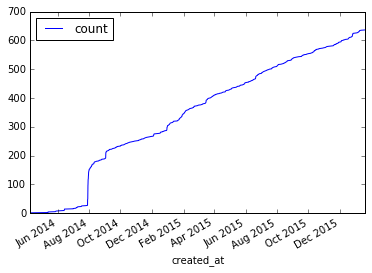

In [109]:
ssum = ts.cumsum()
ssum.plot(kind='line')

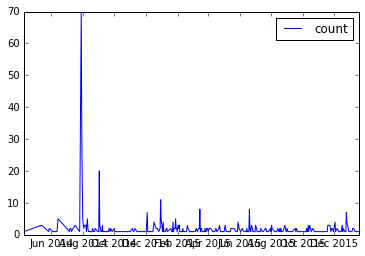

In [119]:
ts_by_day = ts.groupby(lambda x : x.date).sum()
ts_by_day.plot()

所以我们可以看到有几个尖峰，我们来找到这些都是什么？ 

In [126]:
ts_by_day.nlargest(8, columns=['count'])

,count
2014-07-29,70
2014-07-30,34
2014-09-02,20
2014-07-31,17
2014-12-30,11
2015-03-16,8
2015-06-20,8
2014-12-04,7


In [ ]:
我们来最大的尖峰这一天是什么情况？ 

In [147]:
max_day = ts_by_day.nlargest(1, columns=['count']).index[0]
max_day = max_day.strftime("%Y-%m-%d")
ts[max_day]

,actor,count
created_at,,
2014-07-29 02:40:28,iiiyu,1
2014-07-29 02:40:37,maojj,1
2014-07-29 02:41:21,luosky,1
2014-07-29 02:41:58,zzuwangfeng,1
2014-07-29 02:42:50,noark9,1
2014-07-29 02:42:53,noark9,1
2014-07-29 02:42:57,undancer,1
2014-07-29 02:43:28,ewangke,1
2014-07-29 02:43:38,easonoutlook,1


In [ ]:
我们猜想可能是由于某一个 follower 很多的人star 了这个项目所以传播到了很多人。 
我们来画一个这些人的关系图。 

In [135]:
def get_relations(user_names):
    for user_name in user_names:
        for fuser in Github().get_user(user_name).get_followers():
            if fuser.login in user_names:
                yield (user_name, fuser.login)
                

In [136]:
for x in get_relations(ts['2014-07-29']['actor']):
    print (x)

GithubException: 403 {'message': "API rate limit exceeded for 58.34.164.183. (But here's the good news: Authenticated requests get a higher rate limit. Check out the documentation for more details.)", 'documentation_url': 'https://developer.github.com/v3/#rate-limiting'}